- data merge
- outlier 제거
- Bag of Word 속성 추가
- 속성 제거

In [ ]:
!pip install konlpy

# IMPORT LIBARAY

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
#from konlpy.tag import Kkma
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATA CLEANING

- 상품 제목이 금지어에 해당하는 경우 제거
- 상품 가격이 비이상적인 경우 제거

In [ ]:
def remove_outlier(df):

    # 금지어 제거
    ban_word = ['케이스', '매입', '파손', '삽니다', '교신', '구매', '교환', '사요', '구합', '파우치', '키보드', '거치대', '필름']

    # 문자열로 변환
    df['name'] = df['name'].astype(str)

    for w in ban_word:
        df = df[~df['name'].str.contains(w)]

    df = df[df['price'].apply(pd.to_numeric, errors='coerce').notnull()]
    df['price'] = df['price'].astype(int)
    df = df.drop(df[df['price'] >= 1000000].index)
    df = df.drop(df[df['price'] <= 50000].index)

    return df

df_list = []

for i in range(1,7):
  try :
    df = pd.read_csv("drive/MyDrive/SLE_AI_Project/csv/{}.csv".format(str(i)), encoding='cp949')
  except :
    df = pd.read_csv("drive/MyDrive/SLE_AI_Project/csv/{}.csv".format(str(i)))

  df = remove_outlier(df)
  print("{}th Data length is :".format(i+1),len(df))
  df_list.append(df)
  print("{}th Price mean is :".format(i+1) , round(df['price'].mean(), 1))




2th Data length is : 2010
2th Price mean is : 560910.9
3th Data length is : 1614
3th Price mean is : 333051.2
4th Data length is : 4515
4th Price mean is : 203523.6
5th Data length is : 7181
5th Price mean is : 571088.2
6th Data length is : 614
6th Price mean is : 377544.3
7th Data length is : 4598
7th Price mean is : 152361.3


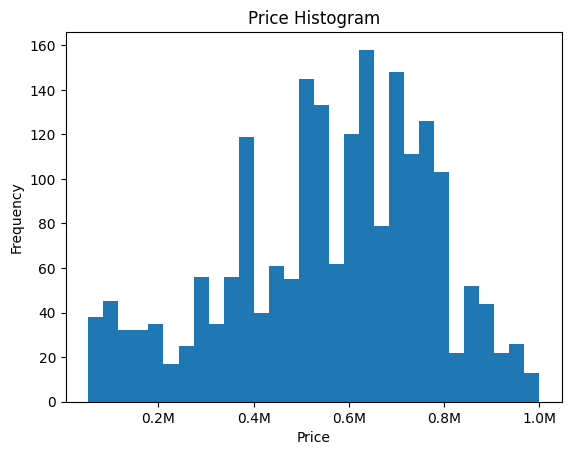

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 데이터가 담긴 리스트 df_list와 첫 번째 데이터프레임인 df_list[0]을 사용한다고 가정합니다.
# 데이터프레임의 'price' 열에 히스토그램을 그리려면 다음과 같이 사용합니다.
plt.hist(df_list[0]['price'], bins=30)

# x 축 눈금 형식을 변경합니다.
def millions_formatter(x, pos):
    # x를 백만으로 나누어 천 단위로 변환하여 표시합니다.
    return '{:.1f}M'.format(x * 1e-6)

# x 축 눈금에 함수 형식을 적용합니다.
x_formatter = ticker.FuncFormatter(millions_formatter)
plt.gca().xaxis.set_major_formatter(x_formatter)

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Histogram')
plt.show()


# MERGE DATA
- 당근마켓 / 번개장터 데이터를 하나의 Dataframe으로 함침
- 데이터가 상품 순서대로 되어있으므로 Random으로 데이터를 섞음

In [ ]:
# 파일들을 반복하면서 읽어와 DataFrame에 추가
merged_df = pd.DataFrame()
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.sample(frac=1, random_state=42)

# KOREAN NLP
- 제목과 상세설명을 하나로 합쳐 Combined_Text에 저장
- Combined_Text에서 konlpy 라이브러리를 사용하여 명사 단위 데이터로 변환
-

In [ ]:
merged_df['Combined_Text'] = merged_df['name'] + ' ' + merged_df['content']


merged_df['Noun_text'] = None
kkma = Kkma()

for i in range(len(merged_df)) :
  print(i, "th Data")

  string_list = kkma.nouns(merged_df['Combined_Text'].iloc[i])
  sentence = ' '.join(string_list)
  merged_df['Noun_text'].iloc[i] = sentence

  print(merged_df['Noun_text'].iloc[i])

In [ ]:
# Result
pd.read_csv('drive/MyDrive/SLE_AI_Project/csv/noun.csv')

In [ ]:
# Bag of Words 변환 수행
texts = merged_df['Noun_text'].tolist()

vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(texts)

# 변환된 결과를 DataFrame에 새로운 열로 추가 // get_feature_names().
for i, feature_name in enumerate(vectorizer.get_feature_names_out()):
  print(i, feature_name)
  merged_df['{}'.format(feature_name)] = bow[:, i].toarray().ravel()



# To Model

이전 작업 데이터 저장 및 불러오기

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_parquet('drive/MyDrive/SLE_AI_Project/csv/bow.parquet')

columns_to_remove = ['Unnamed: 0', 'date']
df.drop(columns=columns_to_remove, inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


빈도수 높은 특성 확인

In [ ]:
tmp = df.copy()
tmp = tmp.select_dtypes(exclude=['object'])

# 열의 합 계산
column_sums = tmp.sum()

# 상위 200개 열만 표시
top_30_sums = column_sums.nlargest(200)
top_30_sums

selected = list(top_30_sums.keys()[2 : ])
df[selected].sum()

In [2]:
# location 열이 있는지 확인
if 'location' in df.columns:
    # location 열이 있을 경우 처리
    for location_str in df['location']:
        # 공백으로 분할하여 첫 번째 단어 가져오기
        first_word = location_str.strip().split(" ")[0]
        # 해당 이름의 열이 이미 존재하는지 확인
        if first_word not in df.columns:
          df[first_word] = 0
else:
    # location 열이 없을 경우 아무 작업도 수행
    pass


<ipython-input-2-f0f2ca37d647>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[first_word] = 0
<ipython-input-2-f0f2ca37d647>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[first_word] = 0
<ipython-input-2-f0f2ca37d647>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[first_word] = 0
<ipy

In [3]:
for location_str in df['location']:
    # 공백으로 분할하여 첫 번째 단어 가져오기
    first_word = location_str.strip().split(" ")[0]
    # 모든 열과 비교하여 일치하는 열의 값을 "1"로 바꿈
    for column in df.columns:
        if first_word == column:
            df.loc[df['location'] == location_str, column] = 1


### state

In [ ]:
# state 열이 '새상품'인 경우 1로 초기화, 그렇지 않은 경우 0으로 초기화
df['state'] = df['state'].apply(lambda x: 1 if x == '새상품' else 0)

# '새상품', '미개봉', '새제품', '새거' 중 하나를 포함하면 해당 행의 state 값을 1로 바꿈
keywords_to_check = ['새상품', '미개봉', '새제품', '새거']
df['state'] = df.apply(lambda row: 1 if any(keyword in str(row['Noun_text']) for keyword in keywords_to_check) else row['state'], axis=1)

df.loc[df['state'] == 1]


In [5]:
df.to_parquet('drive/MyDrive/SLE_AI_Project/csv/done.parquet')

# PCA

In [7]:
columns_to_remove = ['Combined_Text', 'Noun_text','name','content','location']
df.drop(columns=columns_to_remove, inplace=True)

In [8]:
x_train = df[df.columns[~(df.columns == 'price')]]
y_train = df['price']

In [11]:
import numpy as np
from sklearn.decomposition import PCA

# PCA 객체 생성 및 2차원으로 축소
pca = PCA(n_components=6)
data_6d = pca.fit_transform(x_train)

# 결과 출력
print("원본 데이터 크기:", x_train.shape)
print("차원 축소된 데이터 크기:", data_6d.shape)


원본 데이터 크기: (14572, 21427)
차원 축소된 데이터 크기: (14572, 6)


앞으로 해야될 부분들

- Location, state 특징 뽑아내기
- Feature Engineering : 일단 그대로 학습해보고 이상하면 전처리 진행?
- MLP 모델 구현
- 모델 확인 (Maintain)
- 발표 자료


# MODELING

In [21]:
X_s = data_6d
Y_s = y_train

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset

In [24]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):

        self.X = X
        self.Y = Y

    def __len__(self):

        return len(self.X)

    def __getitem__(self, index):
        data_point = self.X[index]
        target = self.Y[index]
        return data_point, target


# 데이터셋을 train과 test로 분할
X_tensor = torch.tensor(X_s, dtype=torch.float32)
Y_tensor = torch.tensor(Y_s, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

# 데이터 로더 생성
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


In [25]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [26]:
# 모델 초기화
input_dim = 6
hidden_dim = 16
output_dim = 1
model = MLPRegressor(input_dim, hidden_dim, output_dim)

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [28]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:

            inputs = inputs.to(torch.float32)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
        loss_list.append(running_loss/len(train_loader))
    return loss_list
# 학습 실행
loss_l = train_model(model, train_loader, criterion, optimizer)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Loss: 75359638542.58844
Epoch 2/50, Loss: 26538641997.15646
Epoch 3/50, Loss: 23521405960.747383
Epoch 4/50, Loss: 23201146091.92404
Epoch 5/50, Loss: 23150368404.98589
Epoch 6/50, Loss: 23132159351.12455
Epoch 7/50, Loss: 23124787232.94045
Epoch 8/50, Loss: 23118348677.626305
Epoch 9/50, Loss: 23110480993.348194
Epoch 10/50, Loss: 23105651508.19589
Epoch 11/50, Loss: 23094294788.06845
Epoch 12/50, Loss: 23092994795.474094
Epoch 13/50, Loss: 23083759746.300095
Epoch 14/50, Loss: 23071628337.7693
Epoch 15/50, Loss: 23070383279.58818
Epoch 16/50, Loss: 23059411387.829815
Epoch 17/50, Loss: 23060490593.105537
Epoch 18/50, Loss: 23053756148.00504
Epoch 19/50, Loss: 23056040603.803696
Epoch 20/50, Loss: 23044444586.804424
Epoch 21/50, Loss: 23049406569.35765
Epoch 22/50, Loss: 23031502814.8468
Epoch 23/50, Loss: 23021075933.93464
Epoch 24/50, Loss: 23026894934.514336
Epoch 25/50, Loss: 23025208001.29638
Epoch 26/50, Loss: 23016012724.408688
Epoch 27/50, Loss: 23013275339.993286


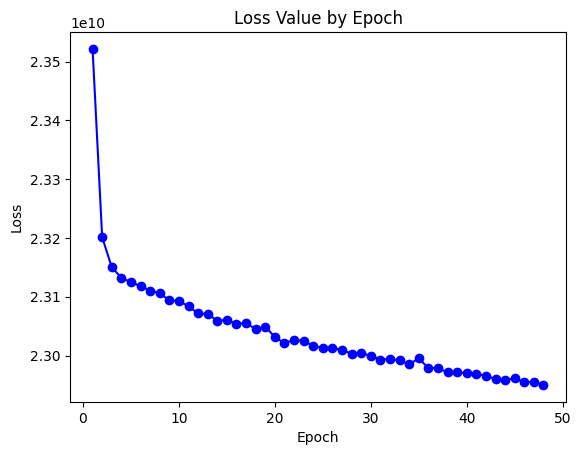

In [31]:
import matplotlib.pyplot as plt

def visualize_loss(epoch_losses):
    # epoch_losses는 epoch에 따른 loss 값이 담긴 리스트입니다.

    # 그래프 그리기
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b')

    # 그래프 제목과 축 레이블 설정
    plt.title('Loss Value by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # 그래프 보여주기
    plt.show()

# 예시: 임의의 epoch_losses 리스트 생성 (이 부분은 실제로는 학습 과정에서 얻은 값들이어야 합니다)

visualize_loss(loss_l[2:])


In [34]:
def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(torch.float32)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss}")
    return avg_loss
# 테스트 실행
train_loss = loss_l[-1]
test_loss = test_model(model, test_loader, criterion)



Test Loss: 22982185434.31743


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [35]:
print("train_loss : ",train_loss,"test_loss : ", test_loss)


train_loss :  22950142188.86387 test_loss :  22982185434.31743


In [44]:
done = pd.read_parquet('drive/MyDrive/SLE_AI_Project/csv/done.parquet')

In [45]:
done[done['price'] == 250000].iloc[0]

name                                         아이패드 6세대+애플펜슬1세대
price                                                  250000
location                                                   전국
content     32GB 아이패드 팝니다\r\n기능 이상 없고 바로 쓸 수 있습니다\r\n파손이나 ...
state                                                       0
                                  ...                        
영암군                                                         0
순창군                                                         0
상주시                                                         0
율천동                                                         0
의령군                                                         0
Name: 129, Length: 21433, dtype: object

In [46]:
done[done['price'] == 720000].iloc[0]

name                             아이패드미니6 256퍼플 셀룰러 애플케어+애플펜슬2
price                                                  720000
location                                             서초구 반포3동
content     구매하고 거의 사용 않은 제품입니다.\r\n11인치 256gb 와이파이 a12z 버...
state                                                       0
                                  ...                        
영암군                                                         0
순창군                                                         0
상주시                                                         0
율천동                                                         0
의령군                                                         0
Name: 15, Length: 21433, dtype: object

In [ ]:
first_batch_data, first_batch_targets = next(iter(test_loader))

In [ ]:
first_batch_data, first_batch_targets

(tensor([[-1.3375, -0.4161, -0.5228,  0.5950,  0.0524, -0.2643],
         [ 1.2966,  2.0759, -0.2752,  0.5389,  0.3690, -0.7420]]),
 tensor([250000., 720000.]))

In [ ]:
model(first_batch_data)

tensor([[142173.4375],
        [808242.3750]], grad_fn=<AddmmBackward0>)